# Group 20 — Exploratory Data Analysis

This notebook performs exploratory data analysis on customer and flights databases, covering data inspection, quality assessment, and preprocessing.

## Table of Contents
- [Data Import](#data-import)
- [Data Inspection](#data-inspection)
  - [Customer DB](#customer-db)
  - [Flights DB](#flights-db)
- [Missing Values](#missing-values)
- [Outliers](#outliers)
  - [Customer DB Outliers](#customer-outliers)
  - [Flights DB Outliers](#flights-outliers)
- [Correlations](#correlations)
- [Miscellaneous Analyses](#miscellaneous)
  - [Categorical Distributions](#categorical-distributions)
  - [Relationship Analysis](#relationship-analysis)
  - [Points Redemption Analysis](#points-redemption)
  - [Geospatial Analysis](#geospatial-analysis)
- [Data Preprocessing](#preprocessing)
- [Clustering](#clustering)

# <a id="data-import"></a> Data Import

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
from scipy import stats
from scipy.stats.mstats import winsorize

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

# Load the data

customer_db = pd.read_csv("data/DM_AIAI_CustomerDB.csv", index_col=0 )
flights_db = pd.read_csv("data/DM_AIAI_FlightsDB.csv")


# <a id="data-inspection"></a> Data Inspection

### <a id="customer-db"></a> Customer DB

## Basic Information

In [3]:
customer_db.head()

,Loyalty#,First Name,Last Name,Customer Name,Country,Province or State,City,Latitude,Longitude,Postal code,Gender,Education,Location Code,Income,Marital Status,LoyaltyStatus,EnrollmentDateOpening,CancellationDate,Customer Lifetime Value,EnrollmentType
0,480934,Cecilia,Householder,Cecilia Householder,Canada,Ontario,Toronto,43.653225,-79.383186,M2Z 4K1,female,Bachelor,Urban,70146.0,Married,Star,2/15/2019,NaN,3839.14,Standard
1,549612,Dayle,Menez,Dayle Menez,Canada,Alberta,Edmonton,53.544388,-113.490930,T3G 6Y6,male,College,Rural,0.0,Divorced,Star,3/9/2019,NaN,3839.61,Standard
2,429460,Necole,Hannon,Necole Hannon,Canada,British Columbia,Vancouver,49.282730,-123.120740,V6E 3D9,male,College,Urban,0.0,Single,Star,7/14/2017,1/8/2021,3839.75,Standard
3,608370,Queen,Hagee,Queen Hagee,Canada,Ontario,Toronto,43.653225,-79.383186,P1W 1K4,male,College,Suburban,0.0,Single,Star,2/17/2016,NaN,3839.75,Standard
4,530508,Claire,Latting,Claire Latting,Canada,Quebec,Hull,45.428730,-75.713364,J8Y 3Z5,male,Bachelor,Suburban,97832.0,Married,Star,10/25/2017,NaN,3842.79,2021 Promotion


In [4]:
customer_db.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16921 entries, 0 to 19
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Loyalty#                 16921 non-null  int64  
 1   First Name               16921 non-null  object 
 2   Last Name                16921 non-null  object 
 3   Customer Name            16921 non-null  object 
 4   Country                  16921 non-null  object 
 5   Province or State        16921 non-null  object 
 6   City                     16921 non-null  object 
 7   Latitude                 16921 non-null  float64
 8   Longitude                16921 non-null  float64
 9   Postal code              16921 non-null  object 
 10  Gender                   16921 non-null  object 
 11  Education                16921 non-null  object 
 12  Location Code            16921 non-null  object 
 13  Income                   16901 non-null  float64
 14  Marital Status           16921

In [5]:
# Check for duplicate loyalty IDs
duplicated_loyalty_ids = customer_db[customer_db['Loyalty#'].duplicated()]['Loyalty#'].unique()
print(f"Number of unique Duplicated Loyalty IDs: {len(duplicated_loyalty_ids)}")

Number of unique Duplicated Loyalty IDs: 163


## <a id="flights-db"></a> Flights DB

In [6]:
flights_db.head()

,Loyalty#,Year,Month,YearMonthDate,NumFlights,NumFlightsWithCompanions,DistanceKM,PointsAccumulated,PointsRedeemed,DollarCostPointsRedeemed
0,413052,2021,12,12/1/2021,2.0,2.0,9384.0,938.0,0.0,0.0
1,464105,2021,12,12/1/2021,0.0,0.0,0.0,0.0,0.0,0.0
2,681785,2021,12,12/1/2021,10.0,3.0,14745.0,1474.0,0.0,0.0
3,185013,2021,12,12/1/2021,16.0,4.0,26311.0,2631.0,3213.0,32.0
4,216596,2021,12,12/1/2021,9.0,0.0,19275.0,1927.0,0.0,0.0


In [7]:
flights_db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 608436 entries, 0 to 608435
Data columns (total 10 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Loyalty#                  608436 non-null  int64  
 1   Year                      608436 non-null  int64  
 2   Month                     608436 non-null  int64  
 3   YearMonthDate             608436 non-null  object 
 4   NumFlights                608436 non-null  float64
 5   NumFlightsWithCompanions  608436 non-null  float64
 6   DistanceKM                608436 non-null  float64
 7   PointsAccumulated         608436 non-null  float64
 8   PointsRedeemed            608436 non-null  float64
 9   DollarCostPointsRedeemed  608436 non-null  float64
dtypes: float64(6), int64(3), object(1)
memory usage: 46.4+ MB


In [8]:
# Check for fractional flight counts
invalid_fractional_flights = flights_db[
    (flights_db['NumFlights'] % 1 != 0) |
    (flights_db['NumFlightsWithCompanions'] % 1 != 0)
]

print(f"Number of rows with fractional flight counts: {len(invalid_fractional_flights)}")
if not invalid_fractional_flights.empty:
    display(invalid_fractional_flights[['Year', 'Month', 'NumFlights', 'NumFlightsWithCompanions']].head(10))

Number of rows with fractional flight counts: 93055


,Year,Month,NumFlights,NumFlightsWithCompanions
405624,2019,1,2.7,0.0
405625,2019,1,9.0,3.6
405626,2019,1,5.4,0.0
405632,2019,1,5.4,0.0
405634,2019,1,2.7,0.0
405635,2019,1,9.0,1.8
405640,2019,1,9.9,0.0
405642,2019,1,7.2,3.6
405643,2019,1,8.1,0.9
405644,2019,1,5.4,5.4


In [9]:
# Check for inconsistent flight records (NumFlights=0 but DistanceKM>0)
invalid_flights = flights_db[(flights_db['NumFlights'] == 0) & (flights_db['DistanceKM'] > 0)]

print(f"Number of inconsistent rows (NumFlights=0 & DistanceKM>0): {len(invalid_flights)}")
if not invalid_flights.empty:
    display(invalid_flights.head())

Number of inconsistent rows (NumFlights=0 & DistanceKM>0): 5901


,Loyalty#,Year,Month,YearMonthDate,NumFlights,NumFlightsWithCompanions,DistanceKM,PointsAccumulated,PointsRedeemed,DollarCostPointsRedeemed
19,261109,2021,12,12/1/2021,0.0,0.0,13736.0,1373.0,0.0,0.0
93,817609,2021,12,12/1/2021,0.0,0.0,23775.0,2377.0,0.0,0.0
96,192600,2021,12,12/1/2021,0.0,0.0,5119.0,511.0,0.0,0.0
116,883242,2021,12,12/1/2021,0.0,0.0,20681.0,2068.0,0.0,0.0
154,493800,2021,12,12/1/2021,0.0,0.0,17502.0,1750.0,0.0,0.0


# <a id="missing-values"></a> Missing Values Analysis

In [10]:
def missing_report(df: pd.DataFrame) -> pd.DataFrame:
    out = df.isna().agg(['sum', 'mean']).T
    out.columns = ['Total', 'Percentage']
    out['Percentage'] = (out['Percentage'] * 100).round(2)
    return out.sort_values(['Total', 'Percentage'], ascending=False)

In [11]:
print("Customer DB Missing Values:")
customer_missing = missing_report(customer_db)
customer_missing

Customer DB Missing Values:


,Total,Percentage
CancellationDate,14611.0,86.35
Income,20.0,0.12
Customer Lifetime Value,20.0,0.12
Loyalty#,0.0,0.00
First Name,0.0,0.00
Last Name,0.0,0.00
Customer Name,0.0,0.00
Country,0.0,0.00
Province or State,0.0,0.00
City,0.0,0.00


In [12]:
print("Flights DB Missing Values:")
flights_missing = missing_report(flights_db)
flights_missing

Flights DB Missing Values:


,Total,Percentage
Loyalty#,0.0,0.0
Year,0.0,0.0
Month,0.0,0.0
YearMonthDate,0.0,0.0
NumFlights,0.0,0.0
NumFlightsWithCompanions,0.0,0.0
DistanceKM,0.0,0.0
PointsAccumulated,0.0,0.0
PointsRedeemed,0.0,0.0
DollarCostPointsRedeemed,0.0,0.0


## Conclusion

**Customer DB:** CancellationDate has 86% missing values (expected for active customers). Income and Customer Lifetime Value have minimal missing data (0.12%). All other columns are complete.

**Flights DB:** No missing values detected. Dataset has excellent completeness.

# <a id="outliers"></a> Outliers Analysis

## <a id="customer-outliers"></a> Customer DB Outliers

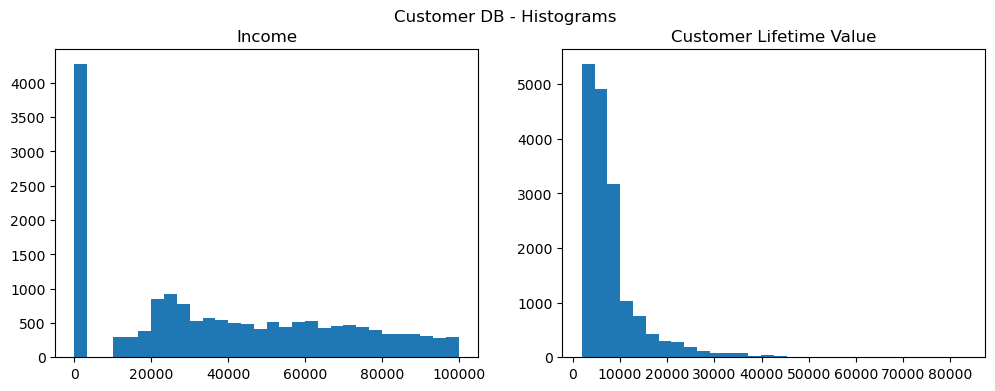

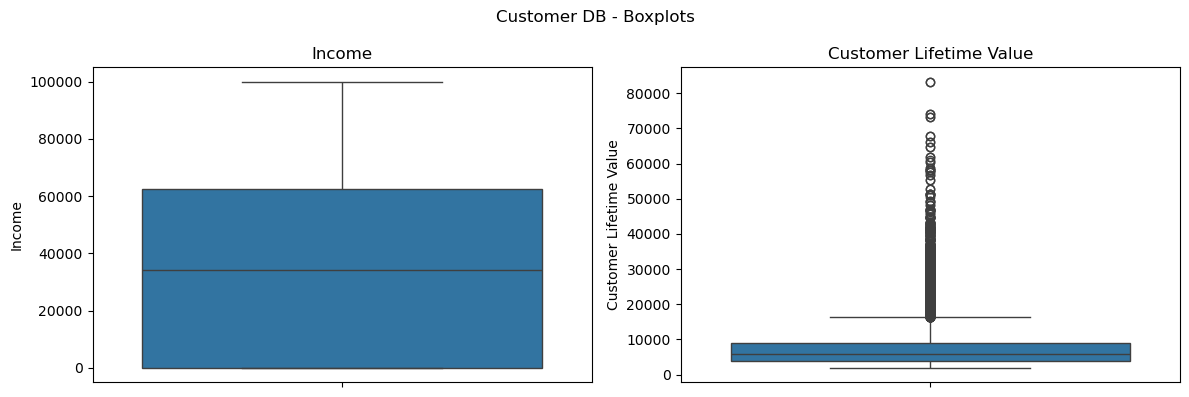

In [13]:
numeric_features = ["Income", "Customer Lifetime Value"]

# Histograms
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
for ax, feat in zip(axes.flatten(), numeric_features):
    ax.hist(customer_db[feat].dropna(), bins=30)
    ax.set_title(feat)
plt.suptitle("Customer DB - Histograms")
plt.show()

# Boxplots
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
for ax, feat in zip(axes.flatten(), numeric_features):
    sns.boxplot(data=customer_db, y=feat, ax=ax)
    ax.set_title(feat)
plt.suptitle("Customer DB - Boxplots")
plt.tight_layout()
plt.show()

## <a id="flights-outliers"></a> Flights DB Outliers

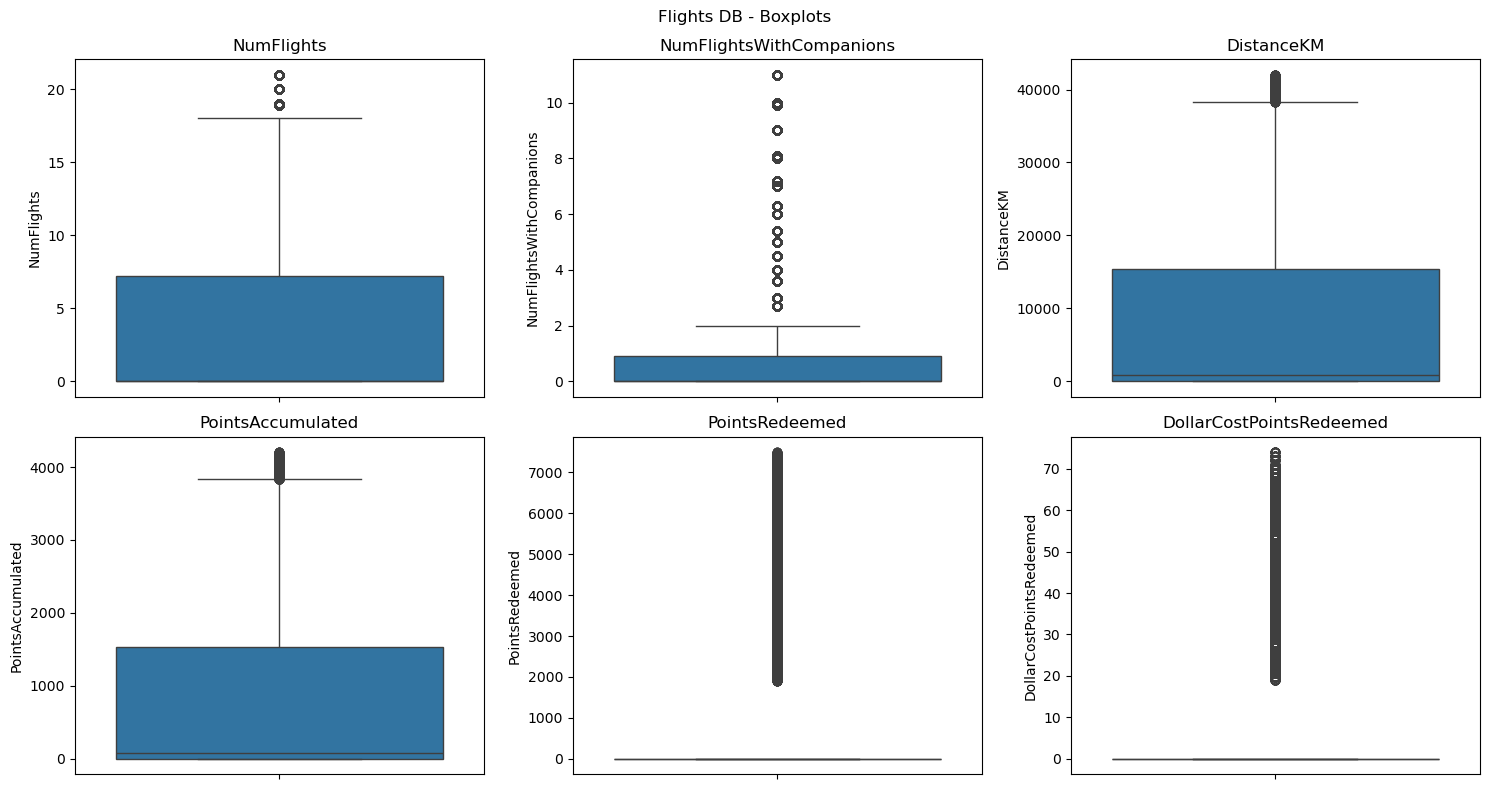

In [14]:
numeric_features = ["NumFlights", "NumFlightsWithCompanions", "DistanceKM", 
                    "PointsAccumulated", "PointsRedeemed", "DollarCostPointsRedeemed"]

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
for ax, feat in zip(axes.flatten(), numeric_features):
    sns.boxplot(data=flights_db, y=feat, ax=ax)
    ax.set_title(feat)
plt.suptitle("Flights DB - Boxplots")
plt.tight_layout()
plt.show()

## Conclusion

**Customer DB:** Both Income and Customer Lifetime Value show right-skewed distributions with numerous outliers. Many customers have zero or near-zero income (likely students), while a small segment has very high income.

**Flights DB:** All flight-related metrics exhibit right skewness with outliers representing highly active frequent flyers. These outliers are legitimate and represent valuable customers rather than data errors.

# <a id="correlations"></a> Correlations Analysis

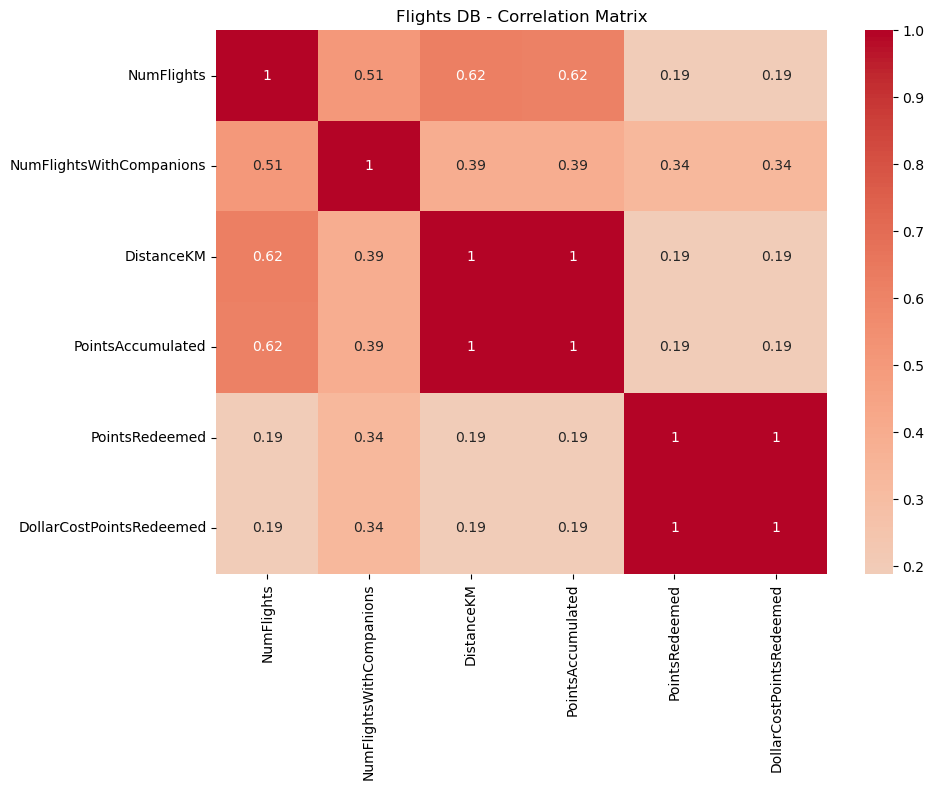

In [15]:
numeric_features = ["NumFlights", "NumFlightsWithCompanions", "DistanceKM", 
                    "PointsAccumulated", "PointsRedeemed", "DollarCostPointsRedeemed"]

corr = flights_db[numeric_features].corr(method="pearson")

fig = plt.figure(figsize=(10, 8))
sns.heatmap(data=corr, annot=True, cmap='coolwarm', center=0)
plt.title("Flights DB - Correlation Matrix")
plt.tight_layout()
plt.show()

## Conclusion

| Pair | Correlation | Interpretation |
|------|--------------|----------------|
| NumFlights and DistanceKM | 0.62 | Strong positive — more flights generally means more total distance flown. |
| NumFlights and PointsAccumulated | 0.62 | Strong positive — more flights results in more points earned. |
| NumFlights and NumFlightsWithCompanions | 0.51 | Moderate positive — people who fly often also tend to fly with companions more. |
| NumFlightsWithCompanions and DistanceKM | 0.39 | Moderate — more companion flights slightly increase total distance. |
| PointsRedeemed and DollarCostPointsRedeemed | 1.00 | Perfect correlation — these two represent the same underlying concept (points redeemed vs. their dollar cost).
| PointsRedeemed and NumFlights / DistanceKM / PointsAccumulated | 0.19–0.34 | Weak relationships — redeeming points doesn’t strongly depend on flying behavior in this dataset. |

# <a id="miscellaneous"></a> Miscellaneous Analyses

## <a id="categorical-distributions"></a> Categorical Distributions

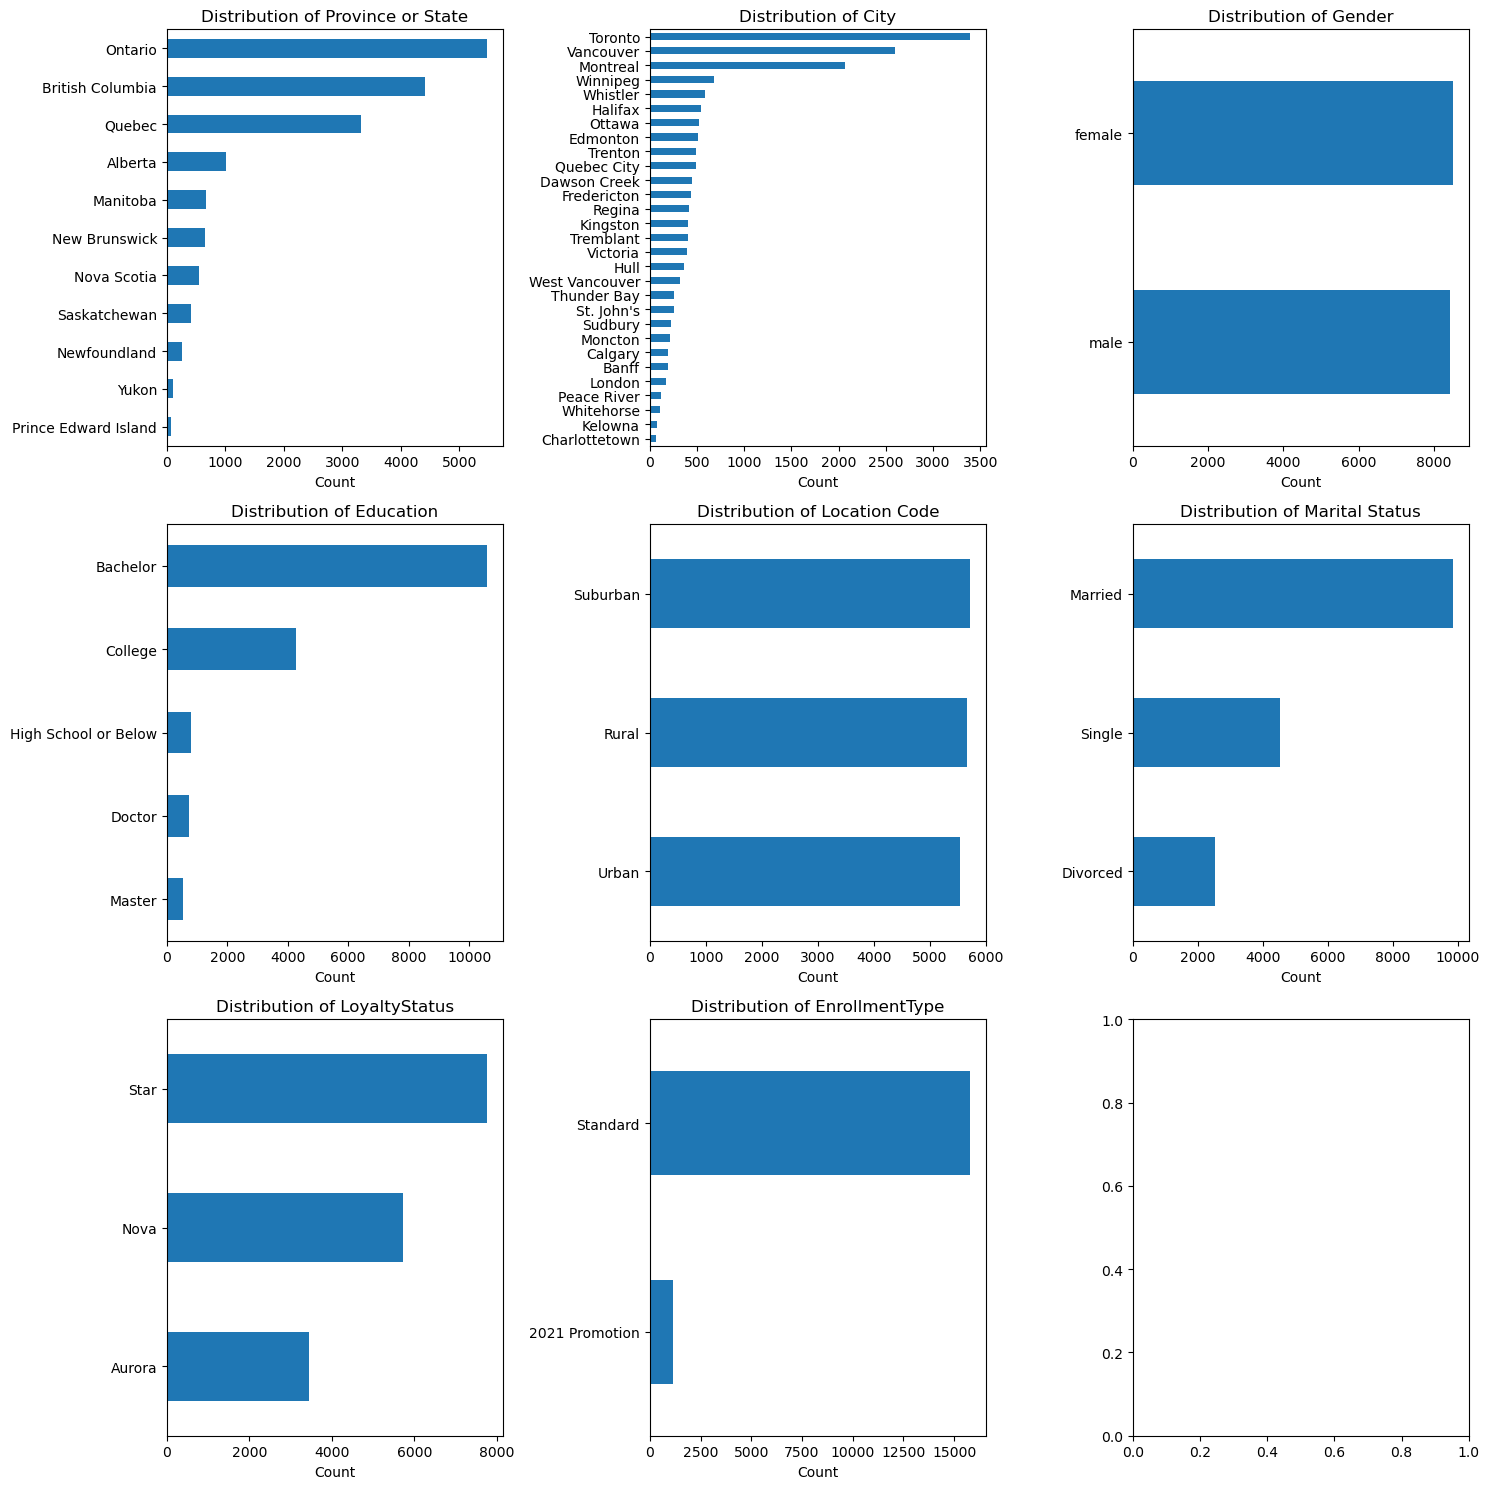

In [16]:
categorical_cols = ['Province or State', 'City', 'Gender', 'Education',
                    'Location Code', 'Marital Status', 'LoyaltyStatus', 'EnrollmentType']

fig, axes = plt.subplots(nrows=math.ceil(len(categorical_cols) / 3), ncols=3, figsize=(15, 15))

for ax, col in zip(axes.flatten(), categorical_cols):
    customer_db[col].value_counts().plot(kind='barh', ax=ax, title=f'Distribution of {col}')
    ax.set_xlabel("Count")
    ax.set_ylabel("")
    ax.invert_yaxis()

plt.tight_layout()
plt.show()

## <a id="relationship-analysis"></a> Relationship Analysis

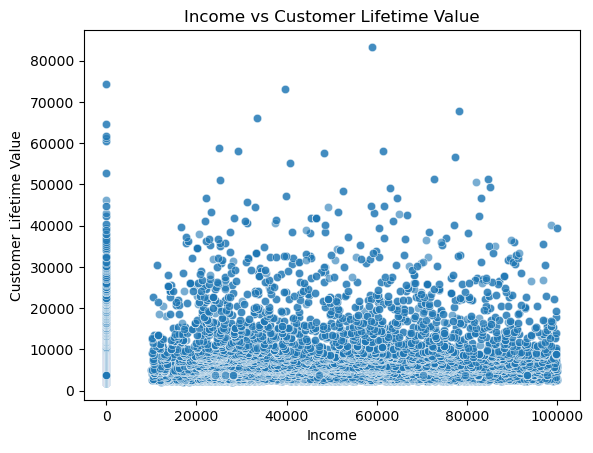

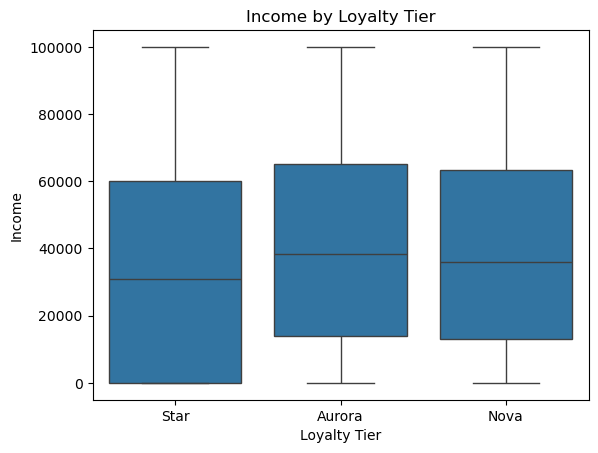

,count,mean,median
LoyaltyStatus,,,
Aurora,3438,40207.368528,38433.5
Nova,5722,38934.271409,36091.0
Star,7741,35800.771606,30817.0


In [17]:
# Customer DB: Income vs Customer Lifetime Value
sns.scatterplot(data=customer_db, x='Income', y='Customer Lifetime Value', alpha=0.6)
plt.title('Income vs Customer Lifetime Value')
plt.show()

# Income by Loyalty Status
sns.boxplot(x='LoyaltyStatus', y='Income', data=customer_db.dropna(subset=['Income']))
plt.title('Income by Loyalty Tier')
plt.xlabel('Loyalty Tier')
plt.ylabel('Income')
plt.show()

# Income statistics by Loyalty Status
customer_db.groupby('LoyaltyStatus')['Income'].agg(['count', 'mean', 'median'])

**Income vs CLV:** Weak relationship indicates that customer value is driven by factors beyond income, such as travel frequency and engagement with loyalty programs.

**Income by Loyalty Status:** Income distribution appears similar across loyalty tiers, suggesting the program is accessible to all income levels.

In [18]:
# ANOVA test: Income vs Education
groups = [group["Income"].dropna() for _, group in customer_db.groupby("Education")]
f_stat, p_val = stats.f_oneway(*groups)
print(f"ANOVA F-statistic: {f_stat:.3f}, p-value: {p_val:.4f}")

ANOVA F-statistic: 8453.611, p-value: 0.0000


**ANOVA Result:** Tests whether income differs significantly across education levels (Bachelor, College, etc.). A low p-value (<0.05) would indicate significant differences in income by education level.

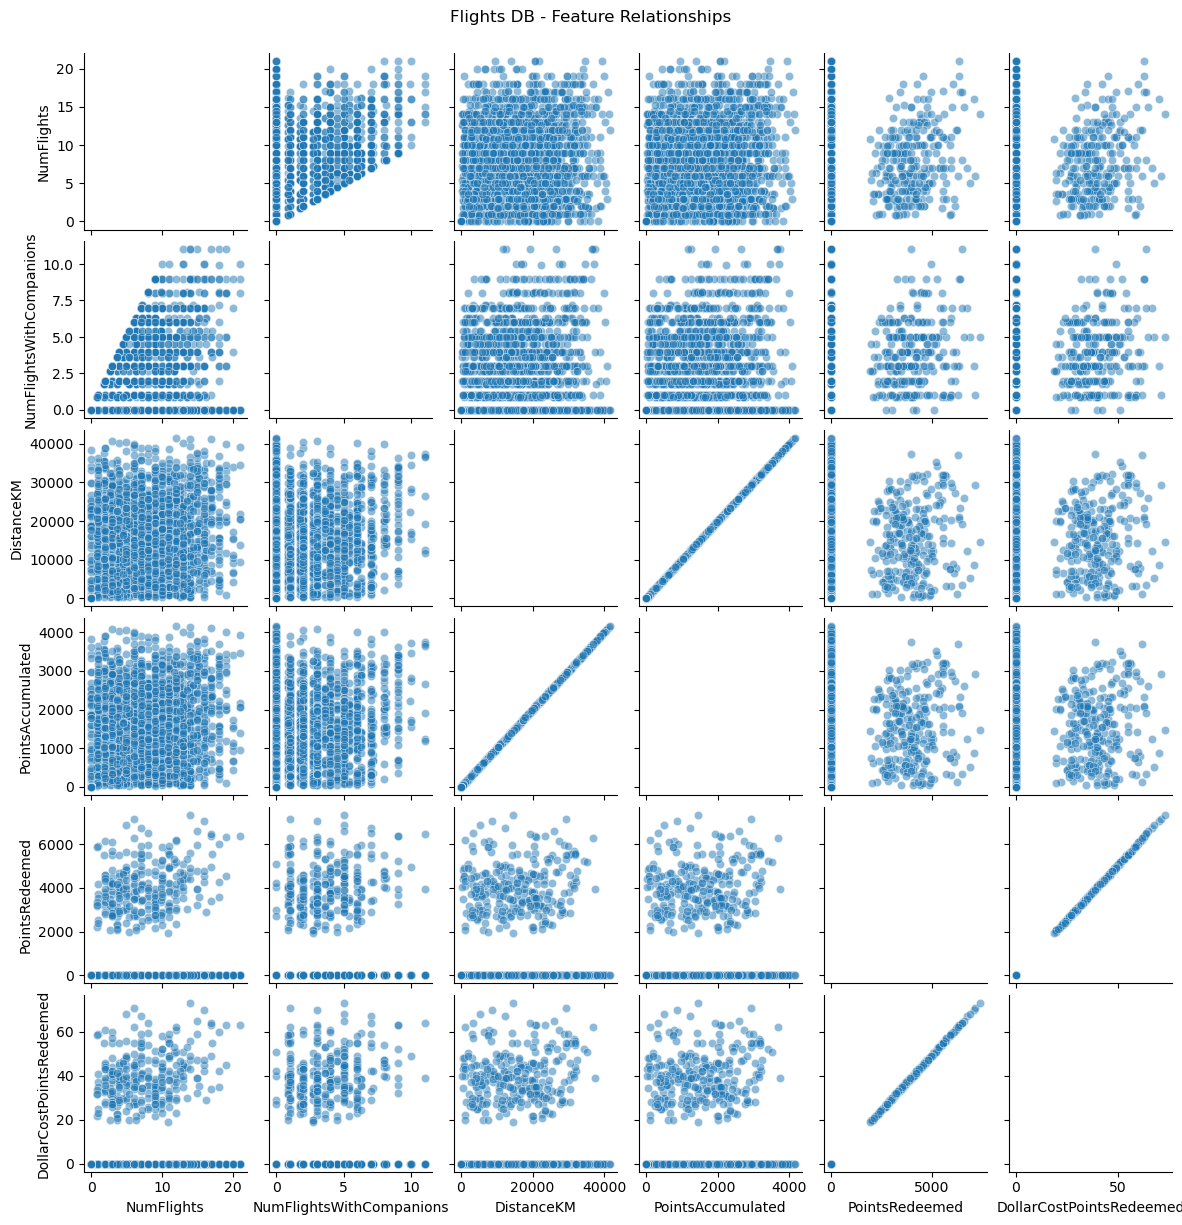

In [19]:
# Flights DB: Pairplot of key features
numeric_features = ["NumFlights", "NumFlightsWithCompanions", "DistanceKM", 
                    "PointsAccumulated", "PointsRedeemed", "DollarCostPointsRedeemed"]

g = sns.pairplot(data=flights_db[numeric_features].sample(5000, random_state=42),
                 diag_kind='scatter', plot_kws={'alpha': 0.5}, height=2)
plt.suptitle('Flights DB - Feature Relationships', y=1.02)
plt.show()

**Pairplot Analysis:** Visualizes relationships between all flight-related features. Strong diagonal patterns indicate perfect correlations (e.g., DistanceKM vs PointsAccumulated), while scattered plots show weak or no relationships (e.g., redemption vs flight activity).

**Key Insights:**
- No clear linear relationship between Income and CLV
- High variance in CLV across all income levels suggests other factors drive customer value
- Strong positive relationships between flight frequency, distance, and points accumulated
- Redemption behavior appears independent of flight activity

## <a id="points-redemption"></a> Points Redemption Analysis

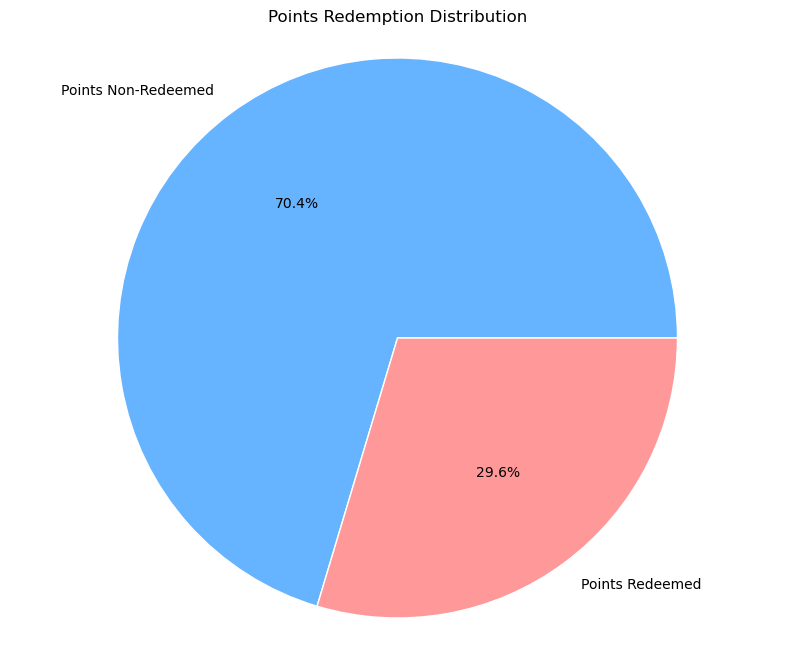

In [20]:
points_accumulated = flights_db['PointsAccumulated'].sum()
points_redeemed = flights_db['PointsRedeemed'].sum()
points_non_redeemed = points_accumulated - points_redeemed

fig, ax = plt.subplots(figsize=(10, 8))
sizes = [points_non_redeemed, points_redeemed]
labels = ['Points Non-Redeemed', 'Points Redeemed']
colors = ['#66b3ff', '#ff9999']

ax.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%',
       wedgeprops={"linewidth": 1, "edgecolor": "white"})
plt.title('Points Redemption Distribution')
plt.axis('equal')
plt.show()

**Points Redemption Overview:** Shows the proportion of loyalty points that have been redeemed vs those still available. High unredeemed percentage suggests opportunity for campaigns to increase engagement.

## <a id="geospatial-analysis"></a> Geospatial Analysis

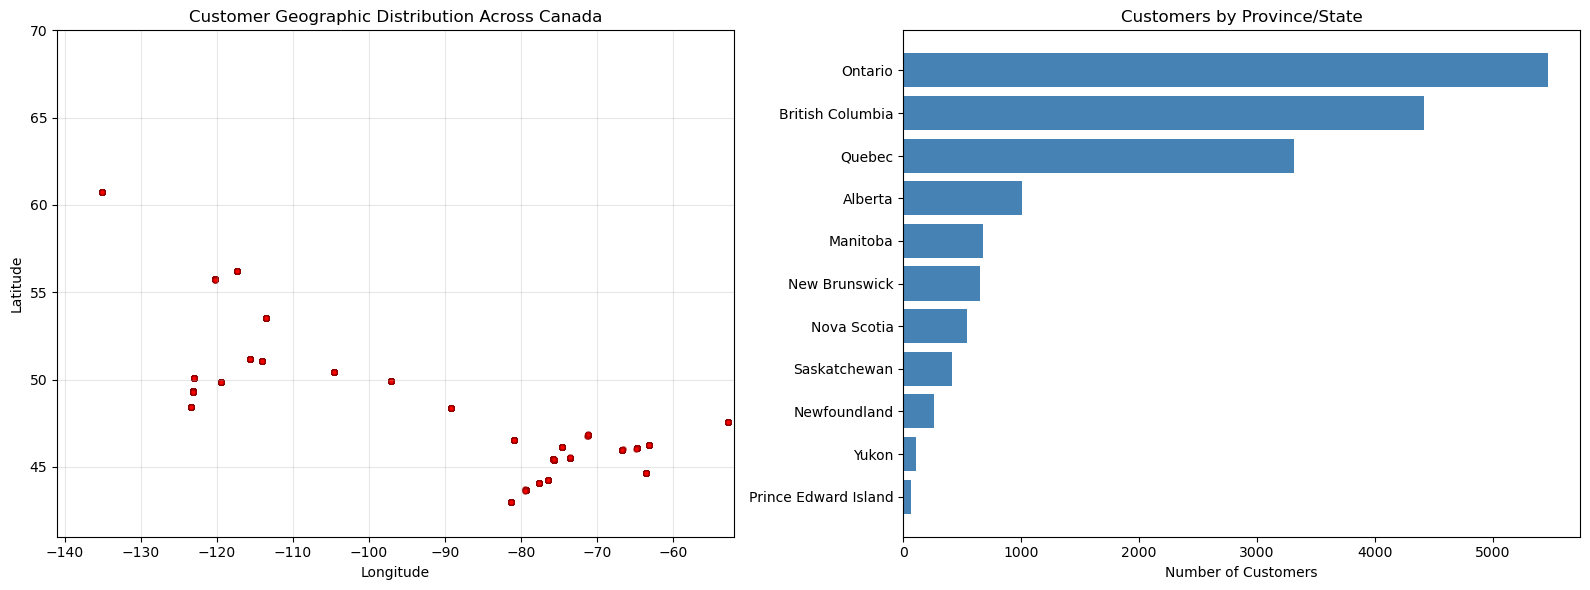

Total unique locations: 49


In [21]:
# Geographic distribution of customers
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Scatter plot of customer locations with Canada boundaries
axes[0].scatter(customer_db['Longitude'], customer_db['Latitude'], alpha=0.6, s=15, c='red', edgecolor='darkred')
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')
axes[0].set_title('Customer Geographic Distribution Across Canada')
axes[0].set_xlim(-141, -52)  # Canada longitude range
axes[0].set_ylim(41, 70)      # Canada latitude range
axes[0].grid(True, alpha=0.3)

# Province distribution
province_counts = customer_db['Province or State'].value_counts()
axes[1].barh(province_counts.index, province_counts.values, color='steelblue')
axes[1].set_xlabel('Number of Customers')
axes[1].set_title('Customers by Province/State')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

print(f"Total unique locations: {customer_db[['Latitude', 'Longitude']].drop_duplicates().shape[0]}")

**Geographic Distribution:** Map shows customer locations concentrated in southern Canada's major urban areas. Eastern provinces (Ontario, Quebec) and western coast (British Columbia) have highest customer density, reflecting population distribution patterns.

# <a id="preprocessing"></a> Data Preprocessing

In this section we apply the preprocessing and feature engineering steps
described in the report:

- Fix data types and logical inconsistencies in **FlightsDB**
- Handle missing values and transform skewed variables in **CustomerDB**
- Create new features: log-transformed variables, points utilisation,
  cancellation flag, customer value score, flight activity score, and
  average flight distance.



In [22]:
import numpy as np

def preprocess_flights(flights_df: pd.DataFrame) -> pd.DataFrame:
    """
    Apply preprocessing steps to the FlightsDB:
    - Convert YearMonthDate to datetime
    - Round down NumFlights and NumFlightsWithCompanions
    - Set DistanceKM = 0 where NumFlights == 0
    - Drop DollarCostPointsRedeemed
    - Add log-transformed versions of skewed variables
    - Create PointsUtilizationRatio = PointsRedeemed / PointsAccumulated
    """
    df = flights_df.copy()

    # 1. YearMonthDate -> datetime
    if 'YearMonthDate' in df.columns:
        df['YearMonthDate'] = pd.to_datetime(df['YearMonthDate'])

    # 2. Round down flight counts and cast to int
    for col in ['NumFlights', 'NumFlightsWithCompanions']:
        if col in df.columns:
            df[col] = np.floor(df[col]).astype(int)

    # 3. Fix logical inconsistency: DistanceKM must be 0 if NumFlights == 0
    if {'NumFlights', 'DistanceKM'}.issubset(df.columns):
        df.loc[df['NumFlights'] == 0, 'DistanceKM'] = 0

    # 4. Drop perfectly correlated variable
    if 'DollarCostPointsRedeemed' in df.columns:
        df = df.drop(columns=['DollarCostPointsRedeemed'])

    # 5. Log transforms for skewed numeric variables
    log_cols = ['DistanceKM', 'PointsAccumulated', 'PointsRedeemed']
    for col in log_cols:
        if col in df.columns:
            df[f'{col}_log'] = np.log1p(df[col])

    # 6. Points utilisation ratio
    if {'PointsRedeemed', 'PointsAccumulated'}.issubset(df.columns):
        denom = df['PointsAccumulated'].replace({0: np.nan})
        df['PointsUtilizationRatio'] = df['PointsRedeemed'] / denom

    return df


def preprocess_customers(customer_df: pd.DataFrame) -> pd.DataFrame:
    """
    Apply preprocessing steps to the CustomerDB:
    - Create cancellation flag from CancellationDate
    - Group-median imputation (by LoyaltyStatus) for Income and Customer Lifetime Value
    - Log transform Customer Lifetime Value
    - Create Location feature (region) from Province or State (placeholder mapping)
    - Create CustomerValueScore composite feature
    """
    df = customer_df.copy()

    # 1. Cancellation flag
    if 'CancellationDate' in df.columns:
        df['CancelledFlag'] = df['CancellationDate'].notna().astype(int)

    # 2. Group-median imputation by LoyaltyStatus
    group_col = 'LoyaltyStatus'
    cols_to_impute = ['Income', 'Customer Lifetime Value']
    for col in cols_to_impute:
        if col in df.columns and group_col in df.columns:
            df[col] = df.groupby(group_col)[col].transform(
                lambda x: x.fillna(x.median())
            )

    # 3. Log transform Customer Lifetime Value (for variance stabilisation)
    if 'Customer Lifetime Value' in df.columns:
        df['CustomerLifetimeValue_log'] = np.log1p(df['Customer Lifetime Value'])

    # 4. Location feature (region mapping) – fill mapping as desired
    if 'Province or State' in df.columns:
        region_map = {
            # Example mapping – adjust to your data
            # 'Ontario': 'Central',
            # 'Quebec': 'Central',
            # 'British Columbia': 'West',
            # 'Alberta': 'West',
            # 'Nova Scotia': 'East',
            # ...
        }
        df['Location'] = df['Province or State'].map(region_map).fillna(df['Province or State'])

    # 5. Customer Value Score (simple composite of CLV and Income)
    clv_col = 'CustomerLifetimeValue_log'
    if clv_col in df.columns:
        clv_scaled = (df[clv_col] - df[clv_col].mean()) / df[clv_col].std(ddof=0)

        if 'Income' in df.columns:
            income_log = np.log1p(df['Income'].clip(lower=0))
            income_scaled = (income_log - income_log.mean()) / income_log.std(ddof=0)
            # Heavier weight on CLV, lighter on Income
            df['CustomerValueScore'] = 0.7 * clv_scaled + 0.3 * income_scaled
        else:
            df['CustomerValueScore'] = clv_scaled

    return df
 

In [23]:
def build_customer_flight_features(flights_df: pd.DataFrame) -> pd.DataFrame:
    """
    Aggregate monthly flight records into customer-level features:
    - TotalFlights, TotalDistanceKM, TotalPointsAccumulated, TotalPointsRedeemed
    - MeanPointsUtilization
    - AverageFlightDistance
    - FlightActivityScore (based on z-scores of flights and distance)
    """
    id_col = 'Loyalty#'
    df = flights_df.copy()

    agg = (
        df
        .groupby(id_col)
        .agg(
            TotalFlights=('NumFlights', 'sum'),
            TotalDistanceKM=('DistanceKM', 'sum'),
            TotalPointsAccumulated=('PointsAccumulated', 'sum'),
            TotalPointsRedeemed=('PointsRedeemed', 'sum'),
            MeanPointsUtilization=('PointsUtilizationRatio', 'mean')
        )
        .reset_index()
    )

    # Average flight distance = total distance / total flights
    agg['AverageFlightDistance'] = agg['TotalDistanceKM'] / agg['TotalFlights'].replace({0: np.nan})

    # FlightActivityScore: combines total flights and distance (z-scores)
    for col in ['TotalFlights', 'TotalDistanceKM']:
        mean = agg[col].mean()
        std = agg[col].std(ddof=0)
        if std == 0:
            agg[f'{col}_z'] = 0
        else:
            agg[f'{col}_z'] = (agg[col] - mean) / std

    agg['FlightActivityScore'] = agg['TotalFlights_z'] + agg['TotalDistanceKM_z']

    return agg


In [24]:
# Run preprocessing for each table
customer_preprocessed = preprocess_customers(customer_db)
flights_preprocessed = preprocess_flights(flights_db)

# Build customer-level flight features
customer_flight_features = build_customer_flight_features(flights_preprocessed)

# Merge into a single modelling dataset (one row per customer)
id_col = 'Loyalty#'
model_df = (
    customer_preprocessed
    .merge(customer_flight_features, on=id_col, how='left')
)

print("Customer-preprocessed shape:", customer_preprocessed.shape)
print("Flights-preprocessed shape:", flights_preprocessed.shape)
print("Model dataset shape:", model_df.shape)

model_df.head()


Customer-preprocessed shape: (16921, 24)
Flights-preprocessed shape: (608436, 13)
Model dataset shape: (16921, 33)


,Loyalty#,First Name,Last Name,Customer Name,Country,Province or State,City,Latitude,Longitude,Postal code,...,CustomerValueScore,TotalFlights,TotalDistanceKM,TotalPointsAccumulated,TotalPointsRedeemed,MeanPointsUtilization,AverageFlightDistance,TotalFlights_z,TotalDistanceKM_z,FlightActivityScore
0,480934,Cecilia,Householder,Cecilia Householder,Canada,Ontario,Toronto,43.653225,-79.383186,M2Z 4K1,...,-0.326717,184.0,476229.8,50699.39,13517.9,0.267219,2588.205435,0.558399,1.228108,1.786507
1,549612,Dayle,Menez,Dayle Menez,Canada,Alberta,Edmonton,53.544388,-113.490930,T3G 6Y6,...,-1.043287,275.0,389938.9,42672.54,22457.8,1.559035,1417.959636,1.690882,0.693025,2.383908
2,429460,Necole,Hannon,Necole Hannon,Canada,British Columbia,Vancouver,49.282730,-123.120740,V6E 3D9,...,-1.043248,116.0,208146.7,23832.41,5479.6,0.947354,1794.368103,-0.287852,-0.434252,-0.722105
3,608370,Queen,Hagee,Queen Hagee,Canada,Ontario,Toronto,43.653225,-79.383186,P1W 1K4,...,-1.043248,191.0,372178.3,38595.63,16331.5,1.171049,1948.577487,0.645513,0.582893,1.228406
4,530508,Claire,Latting,Claire Latting,Canada,Quebec,Hull,45.428730,-75.713364,J8Y 3Z5,...,-0.304330,167.0,344036.5,36916.56,0.0,0.000000,2060.098802,0.346836,0.408389,0.755225


In [ ]:

def winsorize_dataframe(df, columns, limits=(0.01, 0.01)):
    """
    Apply winsorization to each column in `columns`.
    limits=(lower_pct, upper_pct) means: cap values at the 1st and 99th percentile.

    Returns the winsorized copy of df.
    """
    df = df.copy()
    for col in columns:
        if col in df.columns:
            # winsorize returns masked arrays -> convert to normal array
            df[col] = winsorize(df[col], limits=limits).data
    return df


In [26]:
flight_outlier_cols = [
    'TotalFlights',
    'TotalDistanceKM',
    'TotalPointsAccumulated',
    'TotalPointsRedeemed',
    'AverageFlightDistance'
]

customer_flight_features_wins = winsorize_dataframe(
    customer_flight_features,
    columns=flight_outlier_cols,
    limits=(0.01, 0.01)    # winsorize at 1% and 99%
)


In [27]:
customer_outlier_cols = [
    'Income',
    'Customer Lifetime Value',
    'CustomerLifetimeValue_log'
]

customer_preprocessed_wins = winsorize_dataframe(
    customer_preprocessed,
    columns=customer_outlier_cols,
    limits=(0.01, 0.01)
)


In [28]:
id_col = 'Loyalty#'

model_df = (
    customer_preprocessed_wins
    .merge(customer_flight_features_wins, on=id_col, how='left')
)

print("Final model_df shape:", model_df.shape)
model_df.head()


Final model_df shape: (16921, 33)


,Loyalty#,First Name,Last Name,Customer Name,Country,Province or State,City,Latitude,Longitude,Postal code,...,CustomerValueScore,TotalFlights,TotalDistanceKM,TotalPointsAccumulated,TotalPointsRedeemed,MeanPointsUtilization,AverageFlightDistance,TotalFlights_z,TotalDistanceKM_z,FlightActivityScore
0,480934,Cecilia,Householder,Cecilia Householder,Canada,Ontario,Toronto,43.653225,-79.383186,M2Z 4K1,...,-0.326717,184.0,476229.8,50699.39,13517.9,0.267219,2588.205435,0.558399,1.228108,1.786507
1,549612,Dayle,Menez,Dayle Menez,Canada,Alberta,Edmonton,53.544388,-113.490930,T3G 6Y6,...,-1.043287,275.0,389938.9,42672.54,22457.8,1.559035,1417.959636,1.690882,0.693025,2.383908
2,429460,Necole,Hannon,Necole Hannon,Canada,British Columbia,Vancouver,49.282730,-123.120740,V6E 3D9,...,-1.043248,116.0,208146.7,23832.41,5479.6,0.947354,1794.368103,-0.287852,-0.434252,-0.722105
3,608370,Queen,Hagee,Queen Hagee,Canada,Ontario,Toronto,43.653225,-79.383186,P1W 1K4,...,-1.043248,191.0,372178.3,38595.63,16331.5,1.171049,1948.577487,0.645513,0.582893,1.228406
4,530508,Claire,Latting,Claire Latting,Canada,Quebec,Hull,45.428730,-75.713364,J8Y 3Z5,...,-0.304330,167.0,344036.5,36916.56,0.0,0.000000,2060.098802,0.346836,0.408389,0.755225


In [29]:
# Check for remaining missing values
model_df.isna().sum().sort_values(ascending=False).head(15)


CancellationDate             14611
AverageFlightDistance         1549
MeanPointsUtilization         1545
FlightActivityScore             20
TotalDistanceKM_z               20
TotalFlights_z                  20
TotalPointsRedeemed             20
TotalPointsAccumulated          20
TotalDistanceKM                 20
TotalFlights                    20
CustomerValueScore               0
Location                         0
CustomerLifetimeValue_log        0
CancelledFlag                    0
EnrollmentType                   0
dtype: int64

In [30]:
# Drop CancellationDate (flag already exists)
model_df = model_df.drop(columns=['CancellationDate'], errors='ignore')

# Fill average distance for zero-flight customers
model_df['AverageFlightDistance'] = model_df['AverageFlightDistance'].fillna(0)

# Fill points utilization for customers with no point activity
model_df['MeanPointsUtilization'] = model_df['MeanPointsUtilization'].fillna(0)

# Fill ALL flight-related NaNs with 0
flight_cols = [
    'TotalFlights', 'TotalDistanceKM', 'TotalPointsAccumulated',
    'TotalPointsRedeemed', 'MeanPointsUtilization', 'AverageFlightDistance',
    'TotalFlights_z', 'TotalDistanceKM_z', 'FlightActivityScore'
]

for col in flight_cols:
    model_df[col] = model_df[col].fillna(0)


In [32]:
# Numerical features for clustering
numeric_features = [
    'Income',
    'CustomerLifetimeValue_log',
    'CustomerValueScore',
    
    'TotalFlights',
    'TotalDistanceKM',
    'AverageFlightDistance',
    'TotalPointsAccumulated',
    'TotalPointsRedeemed',
    'MeanPointsUtilization',
    'FlightActivityScore',

    'CancelledFlag'
]

# Categorical features to encode
categorical_features = [
    'EnrollmentType',  # Bronze, Silver, Gold ...
    'Location'         # Region/Province after mapping
]


In [33]:
df_selected = model_df[numeric_features + categorical_features].copy()
df_selected.head()


,Income,CustomerLifetimeValue_log,CustomerValueScore,TotalFlights,TotalDistanceKM,AverageFlightDistance,TotalPointsAccumulated,TotalPointsRedeemed,MeanPointsUtilization,FlightActivityScore,CancelledFlag,EnrollmentType,Location
0,70146.0,8.253264,-0.326717,184.0,476229.8,2588.205435,50699.39,13517.9,0.267219,1.786507,0,Standard,Ontario
1,0.0,8.253386,-1.043287,275.0,389938.9,1417.959636,42672.54,22457.8,1.559035,2.383908,0,Standard,Alberta
2,0.0,8.253423,-1.043248,116.0,208146.7,1794.368103,23832.41,5479.6,0.947354,-0.722105,1,Standard,British Columbia
3,0.0,8.253423,-1.043248,191.0,372178.3,1948.577487,38595.63,16331.5,1.171049,1.228406,0,Standard,Ontario
4,97832.0,8.254214,-0.304330,167.0,344036.5,2060.098802,36916.56,0.0,0.000000,0.755225,0,2021 Promotion,Quebec


In [34]:
df_encoded = pd.get_dummies(df_selected, columns=categorical_features, drop_first=True)
df_encoded.head()


,Income,CustomerLifetimeValue_log,CustomerValueScore,TotalFlights,TotalDistanceKM,AverageFlightDistance,TotalPointsAccumulated,TotalPointsRedeemed,MeanPointsUtilization,FlightActivityScore,...,Location_British Columbia,Location_Manitoba,Location_New Brunswick,Location_Newfoundland,Location_Nova Scotia,Location_Ontario,Location_Prince Edward Island,Location_Quebec,Location_Saskatchewan,Location_Yukon
0,70146.0,8.253264,-0.326717,184.0,476229.8,2588.205435,50699.39,13517.9,0.267219,1.786507,...,False,False,False,False,False,True,False,False,False,False
1,0.0,8.253386,-1.043287,275.0,389938.9,1417.959636,42672.54,22457.8,1.559035,2.383908,...,False,False,False,False,False,False,False,False,False,False
2,0.0,8.253423,-1.043248,116.0,208146.7,1794.368103,23832.41,5479.6,0.947354,-0.722105,...,True,False,False,False,False,False,False,False,False,False
3,0.0,8.253423,-1.043248,191.0,372178.3,1948.577487,38595.63,16331.5,1.171049,1.228406,...,False,False,False,False,False,True,False,False,False,False
4,97832.0,8.254214,-0.304330,167.0,344036.5,2060.098802,36916.56,0.0,0.000000,0.755225,...,False,False,False,False,False,False,False,True,False,False


In [35]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_encoded)

X_scaled[:5]


array([[ 1.06862073, -0.76270952, -0.42154618,  0.56623022,  1.24229357,
         0.59190799,  1.32410286,  0.58217805, -0.25048664,  0.88569868,
        -0.39761798,  0.26978251, -0.59425478, -0.20399217, -0.20019046,
        -0.12443234, -0.1817363 ,  1.44725606, -0.06305012, -0.49323119,
        -0.15797495, -0.0816278 ],
       [-1.24436294, -0.76251978, -1.34609924,  1.70616109,  0.70299251,
        -0.43469811,  0.83925221,  1.6234558 ,  0.61888987,  1.18482616,
        -0.39761798,  0.26978251, -0.59425478, -0.20399217, -0.20019046,
        -0.12443234, -0.1817363 , -0.69096273, -0.06305012, -0.49323119,
        -0.15797495, -0.0816278 ],
       [-1.24436294, -0.76246326, -1.34604875, -0.28558625, -0.43317279,
        -0.10449122, -0.29875948, -0.35408554,  0.20723573, -0.37040044,
         2.51497678,  0.26978251,  1.6827799 , -0.20399217, -0.20019046,
        -0.12443234, -0.1817363 , -0.69096273, -0.06305012, -0.49323119,
        -0.15797495, -0.0816278 ],
       [-1.24436294

## Clustering

First, we do the Elbow Method for evaluating K-Means cluster candidates

In [ ]:
inertia_values = []
k_values = range(2, 11)

for k in k_values:
    kmclust = KMeans(
        n_clusters=k,
        init="k-means++",
        n_init=15,
        random_state=1
    )
    kmclust.fit(X_scaled)
    inertia_values.append(kmclust.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia_values, marker="o")
plt.title("Elbow Method - Inertia vs Number of clusters (k)")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")
plt.grid(True)
plt.show()


For each candidate value of `k` from 2 to 10, K-Means is fitted and the average silhouette score is computed.  

In [ ]:
range_clusters = range(2, 11)
avg_silhouette = []

for nclus in range_clusters:
    kmclust = KMeans(
        n_clusters=nclus,
        n_init=10,
        random_state=1
    )
    
    cluster_labels = kmclust.fit_predict(X_scaled)
    
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    avg_silhouette.append(silhouette_avg)
    
    print(f"For n_clusters = {nclus}, the average silhouette_score is: {silhouette_avg:.4f}")
